In [1]:
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
import seaborn as sns
import anndata as an
import scanpy as sc

from sklearn.model_selection import train_test_split
from sklearn.model_selection import LeaveOneOut, cross_val_score, cross_val_predict
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, ConfusionMatrixDisplay

In [2]:
data_path = '../SourceData/Extended_Figure10/'

# Read Gene Dataset

In [3]:
st_ad = sc.read_h5ad(data_path + 'st_ad_all.h5ad')
st_ad_recorded = sc.read_h5ad(data_path + 'ad_ephy.h5ad')


# Random Forest model

## 1) Predict Niche from gene expression

In [4]:
st_ad_cm = st_ad[st_ad.obs['cell_type'].isin(['CM_s1', 'CM_s2', 'CM_s3'])]
sc.pp.scale(st_ad_cm)


/opt/anaconda3/envs/graphene_electro_seq/lib/python3.8/site-packages/scanpy/preprocessing/_simple.py:843: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)


In [5]:
X_mol = st_ad_cm.X

y_mol = st_ad_cm.obs['niche']

X_train, X_test, y_train, y_test = train_test_split(
    X_mol, 
    y_mol, 
    test_size=0.20,  
    random_state=42, 
    stratify=y_mol    
)

print(f"Training on {X_train.shape[0]} cells, testing on {X_test.shape[0]} cells.")

rf_mol = RandomForestClassifier(
    n_estimators=100, 
    random_state=42
)

print("Training molecular model...")
rf_mol.fit(X_train, y_train)

print("Evaluating model...")
y_pred = rf_mol.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
print(f"\n--- Molecular Model Results ---")
print(f"Accuracy: {accuracy * 100:.2f}%")

print("\nClassification Report:")
print(classification_report(y_test, y_pred))

gene_names = st_ad_cm.var_names

importances = rf_mol.feature_importances_
feature_imp_df = pd.DataFrame(
    {'Gene': gene_names, 'Importance': importances}
).sort_values(by='Importance', ascending=False)

print("\nTop 10 Most Predictive Genes:")
print(feature_imp_df.head(10))

Training on 2268 cells, testing on 568 cells.
Training molecular model...
Evaluating model...

--- Molecular Model Results ---
Accuracy: 98.24%

Classification Report:
              precision    recall  f1-score   support

     Niche_1       0.99      0.96      0.98       195
     Niche_2       0.97      0.99      0.98       238
     Niche_3       0.99      1.00      1.00       135

    accuracy                           0.98       568
   macro avg       0.98      0.98      0.98       568
weighted avg       0.98      0.98      0.98       568


Top 10 Most Predictive Genes:
         Gene  Importance
42       SPP1    0.065319
71        IL6    0.053123
81       MMP9    0.051153
163  SERPINB2    0.050891
115      GJA5    0.046130
141      CDH5    0.040924
175    PECAM1    0.037099
229      ESAM    0.036657
93       TBXT    0.035293
113      GDF7    0.024267


Plotting molecular model confusion matrix...


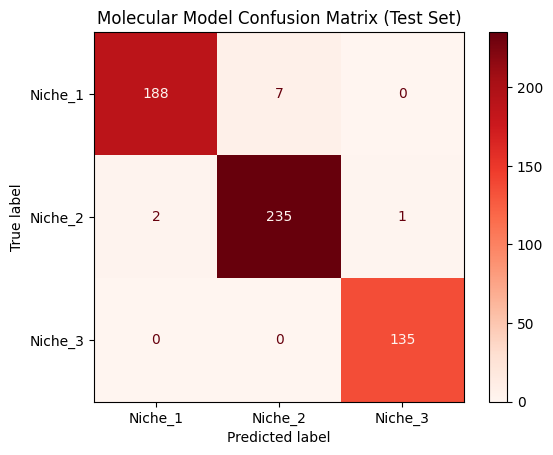

In [6]:
niche_labels = sorted(y_mol.unique()) 

cm = confusion_matrix(
    y_test, 
    y_pred, 
    labels=niche_labels
)

print("Plotting molecular model confusion matrix...")

disp = ConfusionMatrixDisplay(
    confusion_matrix=cm, 
    display_labels=niche_labels
)

disp.plot(cmap='Reds', colorbar=True) 
plt.title('Molecular Model Confusion Matrix (Test Set)')
plt.show()

/var/folders/qc/my6pktfj2x37y67dq8r1g28c0000gn/T/ipykernel_50154/4003894783.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


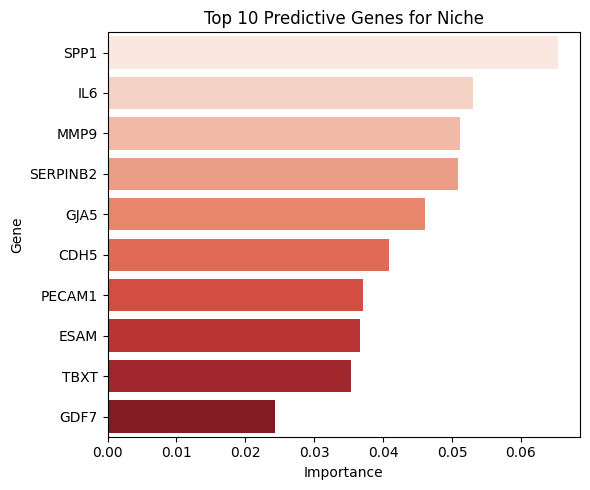

In [7]:
plt.figure(figsize=(6, 5))
sns.barplot(
    x='Importance', 
    y='Gene', 
    data=feature_imp_df.head(10),
    palette='Reds'
)
plt.title('Top 10 Predictive Genes for Niche')
plt.tight_layout()
plt.show()

## 2) Predict Niche from ephys state

In [8]:
st_ad_recorded

AnnData object with n_obs × n_vars = 34 × 62
    obs: 'Unique_cell_id', 'cell_type', 'condition', 'niche', 'ephy_pca1'
    var: 'mean', 'std'
    uns: 'Field Potential Duration (s)', 'Max dVdt', 'Spike Amplitude', 'neighbors', 'pca'
    obsm: 'X_pca'
    varm: 'PCs'

In [9]:
st_ad_recorded.obs['niche'] = st_ad_recorded.obs['niche'].astype(str)

st_ad_recorded.obs['niche'] = st_ad_recorded.obs['niche'].replace({
    '0': 'Niche_2',
    '1': 'Niche_3',
    '2': 'Niche_1'
})

print(st_ad_recorded.obs['niche'].value_counts())

niche
Niche_3    19
Niche_1     8
Niche_2     7
Name: count, dtype: int64


In [10]:
X_ephys = st_ad_recorded.X
y_ephys = st_ad_recorded.obs['niche']

print(f"Running LOOCV on {X_ephys.shape[0]} cells with {X_ephys.shape[1]} features.")

rf_ephys = RandomForestClassifier(
    n_estimators=100, 
    random_state=42
)

loocv = LeaveOneOut()

print("Training functional model with LOOCV...")
scores = cross_val_score(
    rf_ephys, 
    X_ephys, 
    y_ephys, 
    cv=loocv, 
    scoring='accuracy'
)

accuracy_loocv = np.mean(scores)
correct_predictions = np.sum(scores)

print(f"\n--- Functional Model (LOOCV) Results ---")
print(f"Correctly predicted {int(correct_predictions)} out of {len(y_ephys)} cells.")
print(f"Accuracy: {accuracy_loocv * 100:.2f}%")

Running LOOCV on 34 cells with 62 features.
Training functional model with LOOCV...

--- Functional Model (LOOCV) Results ---
Correctly predicted 28 out of 34 cells.
Accuracy: 82.35%


Generating LOOCV predictions for confusion matrix...


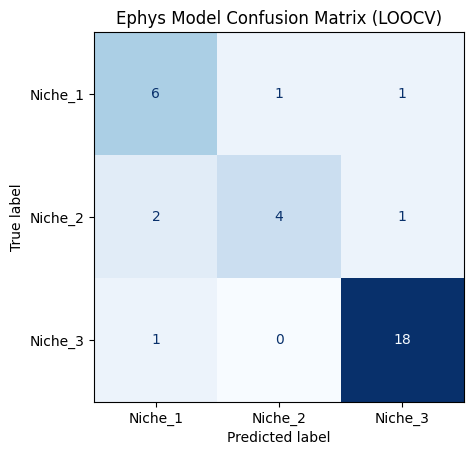

In [11]:
print("Generating LOOCV predictions for confusion matrix...")
y_pred_loocv = cross_val_predict(
    rf_ephys, 
    X_ephys, 
    y_ephys, 
    cv=loocv
)

niche_labels = ['Niche_1', 'Niche_2', 'Niche_3']

cm = confusion_matrix(
    y_ephys, 
    y_pred_loocv, 
    labels=niche_labels
)

disp = ConfusionMatrixDisplay(
    confusion_matrix=cm, 
    display_labels=niche_labels
)

disp.plot(cmap='Blues', colorbar=False)
plt.title('Ephys Model Confusion Matrix (LOOCV)')
plt.show()